## Grover's Algorithm

This notebook serves to implement Grover's Algorithm in a Jupyter Notebook. Grover's Algorithm is known as the quantum search algorithm. It is used to find a unique input to a black box function that produces a particular output value, or set of output values. Here we are creating a two qubit algorithm, but higher level algorithms are possible.



### Imports

First, we begin with a series of import statements. We need a number of general Python tools for plotting and analysis. We also need a number of tools from qiskit to create, run, and visualize our quantum circuit. 

In [46]:
# Python Tools

import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Qiskit Tools

from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

In [49]:
# Set devices, if using a real device
#IBMQ.delete_account()
IBMQ.save_account('d13441a5309e77ae0cfa5a39118c52d327bc9b06ed299cd798ae12e2dacd09c56a4ea00be8cd60f81aed87a994f85fa5b50e7d3ee1710bef99b05a90ca91a9c5')
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_belem')

### Creating the Circuit

Now that the imports are complete, we want to initialize our quantum circuit. In this circuit, we want to make a state for the algorithm to recover. We begin by intitializing a two qubit circuit sent into a superposition by two Haddamard gates.

In [3]:
#Create and set up the intial circuit

grover_circ = QuantumCircuit(2)
grover_circ.h([0,1])

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [57]:
#Visualize the circuit
grover_circ.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

### Applying the Oracle Matrix and the Diffuser

Now we need to add the components onto this circuit to make it function as a two qubit Grover's Algorithm. These components are the Oracle Matrix and the Diffuser. Starting with the Oracle Matrix, which in our case is a CZ gate:

In [26]:
# Create the CZ gate

grover_circ.cz(0,1)

In [35]:
grover_circ.data.pop()

(<qiskit.circuit.library.standard_gates.h.HGate at 0x7f9ff8084610>,
 [Qubit(QuantumRegister(2, 'q'), 0)],
 [])

In [37]:
#Apply the Diffuser

grover_circ.h([0,1])
grover_circ.z([0,1])
grover_circ.cz(0,1)
grover_circ.h([0,1])

In [50]:
# Execute and get counts

tic = time.time()
transpiled_circuit = transpile(grover_circ, quito) # transpile: compile onto a usable platform
job_real = quito.run(transpiled_circuit, shots=1000)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
22.25277304649353


In [52]:
counts = result_real.get_counts(grover_circ)
print(counts)

{}


ValueError: max() arg is an empty sequence

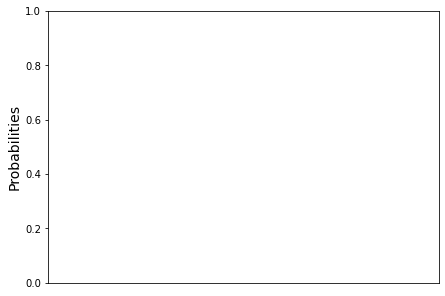

In [53]:
plot_histogram(counts)